In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
if 'SUMO_HOME' in os.environ:
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
import traci
import traci.constants as tc

In [2]:
sumoBinary = "/usr/bin/sumo-gui"
sumoCmd = [sumoBinary, "-c", "osm.sumocfg"]

Códigos para cada uma das variáveis de subscribe:

In [3]:
SPEED = 64
POSITION = 66
ACCELERATION = 114
ANGLE = 67
DEPATURE = 58

Recebendo todas as variáveis para cada instante de execução e armazenando em all_variables:

In [4]:
def setSpeedMode(vehID, speedMode):
    # bit0: Regard safe speed
    # bit1: Regard maximum acceleration
    # bit2: Regard maximum deceleration
    # bit3: Regard right of way at intersections (only applies to approaching foe vehicles outside the intersection)
    # bit4: Brake hard to avoid passing a red light
    # bit5: Disregard right of way within intersections (only applies to foe vehicles that have entered the intersection)

    # CAUTION: 
    # bit5 has inverted semantics and must be set to '1' in order to disable the safety function. This achieves backward compatibility with earlier versions of SUMO where this bit was not defined and right of way within intersection could not be ignored explicitly.

    if vehID in traci.vehicle.getIDList():
        traci.vehicle.setSpeedMode(vehID, speedMode)

In [5]:
def setSpeed(vehID, speed):
    # Sets the speed of the vehicle to max(speed, MaxVehicleSpeed)
    if vehID in traci.vehicle.getIDList():
        traci.vehicle.setSpeed(vehID, speed)

In [7]:
def slowDown(vehID, targetSpeed, duration):
    # Slows down the vehicle to targetSpeed over the next duration seconds
    if vehID in traci.vehicle.getIDList():
        traci.vehicle.slowDown(vehID, targetSpeed, duration)

In [8]:
def get_all_variables(vehIDs, personIDs, useGui=False):
    if useGui:
        traci.start(["sumo-gui", "-c", "osm.sumocfg"])
    else:
        traci.start(["sumo", "-c", "osm.sumocfg"])
    v_variables = {}
    p_variables = {}
    time = 0
    while traci.simulation.getMinExpectedNumber() > 0:
        for veh_id in traci.simulation.getDepartedIDList():
            if veh_id in vehIDs:
                traci.vehicle.subscribe(veh_id, [tc.VAR_POSITION, tc.VAR_SPEED, tc.VAR_ACCELERATION, tc.VAR_ANGLE])
        
        for person_id in traci.simulation.getDepartedPersonIDList():
            if person_id in personIDs:
                traci.person.subscribe(person_id, [tc.VAR_POSITION, tc.VAR_SPEED])

        v_variables[time] = traci.vehicle.getAllSubscriptionResults().copy()
        p_variables[time] = traci.person.getAllSubscriptionResults().copy()
        
        # if time == 0:
        #     setSpeedMode("veh7", 0b10000) 

        # if time == 50:
        #     traci.vehicle.setMaxSpeed("veh7", 20)
        #     setSpeed("veh7", 20)

        # if time == 80:
        #     slowDown("veh7", 0, 20)
        
        time += 1
        traci.simulationStep()
        
    traci.close()
    return v_variables, p_variables

In [9]:
def get_departure_arrival(variables, ID):
    # Devolve o tempo de depareture e arrival de um veículo ou pessoa
    departure = 0
    arrival = 0
    departed = False
    arrived = False
    for x in range(len(variables)):
        if ID in variables[x] and variables[x][ID] and not departed:
            departed = True
            departure = x
        elif ID not in variables[x] and departed:
            arrival = x
            arrived = True
            break
    if not arrived:
        arrival = len(variables)
    return departure, arrival

Função para o plot das variáveis

In [10]:
def static_plots(variables, ID, isVehicle=True):
    # Plots speed, acceleration, angle and position of a vehicle
    plt.ioff()
    departure, arrival = get_departure_arrival(variables, ID)
    time = np.arange(departure, arrival, 1.0)
    
    if isVehicle:
        fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    else:
        fig, ax = plt.subplots(1, 2, figsize=(18, 5))

    if isVehicle:
        speed = [variables[x][ID][SPEED] for x in range(len(variables)) if ID in variables[x]]
        ax[0,0].plot(time, speed, label='Speed', color='b')
        ax[0,0].set_xlabel('Simulation step')
        ax[0,0].set_ylabel('Speed (m/s)')
        ax[0,0].legend()

        pos = [variables[x][ID][POSITION] for x in range(len(variables)) if ID in variables[x]]
        ax[1,1].plot([p[0] for p in pos], [p[1] for p in pos], label='Position', color='y')
        ax[1,1].set_xlabel('X pos')
        ax[1,1].set_ylabel('Y pos')

        acc = [variables[x][ID][ACCELERATION] for x in range(len(variables)) if ID in variables[x]]
        ax[0,1].plot(time, acc, color='g')
        ax[0,1].set_xlabel('Simulation step')
        ax[0,1].set_ylabel('Acceleration(m/s²)')
        ax[0,1].legend()

        angle = [variables[x][ID][ANGLE] for x in range(len(variables)) if ID in variables[x]]
        ax[1,0].plot(time, angle, color='purple')
        ax[1,0].set_xlabel('Simulation step')
        ax[1,0].set_ylabel('Angle (degrees)')

    else:
        speed = [variables[x][ID][SPEED] for x in range(len(variables)) if ID in variables[x]]
        ax[0].plot(time, speed, color='b')
        ax[0].set_xlabel('Simulation step')
        ax[0].set_ylabel('Speed (m/s)')
        ax[0].legend()

        pos = [variables[x][ID][POSITION] for x in range(len(variables)) if ID in variables[x]]
        ax[1].plot([p[0] for p in pos], [p[1] for p in pos], label='Position', color='y')
        ax[1].set_xlabel('X pos')
        ax[1].set_ylabel('Y pos')   

    plt.show()

In [11]:
def overleaf_static_plots(variables, ID, xlim, isVehicle=True):
    # Plots speed, acceleration, and angle of a vehicle
    plt.ioff()
    departure, arrival = get_departure_arrival(variables, ID)
    time = np.arange(departure, min(arrival, departure + xlim), 1.0)
    fig, ax = plt.subplots(1, 3, figsize=(25, 5))

    speed = [variables[x][ID][SPEED] for x in range(len(variables)) if ID in variables[x]]
    ax[0].plot(time, speed[:xlim], color='b')
    ax[0].set_xlabel('Simulation step')
    ax[0].set_ylabel('Speed (m/s)')
    # ax[0].set_xlim(xlim)

    acc = [variables[x][ID][ACCELERATION] for x in range(len(variables)) if ID in variables[x]]
    ax[1].plot(time, acc[:xlim], color='g')
    ax[1].set_xlabel('Simulation step')
    ax[1].set_ylabel('Acceleration (m/s²)')
    # ax[1].set_xlim(xlim)

    angle = [variables[x][ID][ANGLE] for x in range(len(variables)) if ID in variables[x]]
    ax[2].plot(time, angle[:xlim], color='purple')
    ax[2].set_xlabel('Simulation step')
    ax[2].set_ylabel('Angle (degrees)')
    # ax[2].set_xlim(xlim)

    plt.show()

In [12]:
vehIDs = ["veh1", "veh2", "veh3"]
personIDs = []

In [13]:
try:
    veh_variables, ped_variables = get_all_variables(vehIDs, personIDs, useGui=False)
except Exception as e:
    traci.close()
    print(f"An error occurred: {e}")

 Retrying in 1 seconds
***Starting server on port 44863 ***
Loading net-file from 'osm.net.xml.gz' ... done (577ms).
Loading additional-files from 'osm_stops.add.xml' ... done (30ms).
Loading additional-files from 'pa_rerouter.xml' ... done (880ms).
Loading done.
Simulation version 1.21.0 started with time: 0.00.


Simulation ended at time: 1538.00.
Reason: TraCI requested termination.
Performance:
 Duration: 2.83s
 TraCI-Duration: 0.55s
 Real time factor: 543.847
 UPS: 2403.111740
 UPS-Persons: 830.622348
Vehicles:
 Inserted: 15
 Running: 0
 Waiting: 0
Persons:
 Inserted: 9
 Running: 0
Statistics (avg of 15):
 RouteLength: 4984.61
 Speed: 11.18
 Duration: 453.07
 WaitingTime: 0.60
 TimeLoss: 119.49
 DepartDelay: 1.40
Pedestrian Statistics (avg of 9 walks):
 RouteLength: 298.88
 Duration: 261.00
 TimeLoss: 26.34
DijkstraRouter answered 34 queries and explored 6.79 edges on average.
DijkstraRouter spent 0.00s answering queries (0.00ms on average).
DijkstraRouter answered 37 queries and explored 493.16 edges on average.
DijkstraRouter spent 0.02s answering queries (0.49ms on average).


In [14]:
# Separate images for each sensor
def separate_plots(variables, sensor_values, sensor_names, ID, xlim, name = "vehicle"):
    plt.ioff()
    departure, arrival = get_departure_arrival(variables, ID[0])
    time_agg = np.arange(departure, min(arrival, departure + xlim), 1.0)
    departure, arrival = get_departure_arrival(variables, ID[1])
    time_normal = np.arange(departure, min(arrival, departure + xlim), 1.0)

    colors = ['r', 'g', 'b', 'black']

    for i in range(len(sensor_values)):
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))

        value_agg = [variables[x][ID[0]][sensor_values[i]] for x in range(len(variables)) if ID[0] in variables[x]]
        value_normal = [variables[x][ID[1]][sensor_values[i]] for x in range(len(variables)) if ID[1] in variables[x]]

        if sensor_values[i] == POSITION:
            ax[0].plot([p[0] for p in value_agg], [p[1] for p in value_agg], label='Position', color=colors[i])
            ax[1].plot([p[0] for p in value_normal], [p[1] for p in value_normal], label='Position', color=colors[i])
            ax[0].set_xlabel('x')
            ax[1].set_xlabel('x')
            ax[0].set_ylabel(f'y')
            ax[1].set_ylabel(f'y')

        else:
            ax[0].plot(time_agg, value_agg[:xlim], color=colors[i])
            ax[1].plot(time_normal, value_normal[:xlim], color=colors[i])
            ax[0].set_xlabel('Simulation step')
            ax[1].set_xlabel('Simulation step')
            ax[0].set_ylabel(f'{sensor_names[i]}')
            ax[1].set_ylabel(f'{sensor_names[i]}')

        ax[0].set_title('Aggressive style')
        ax[1].set_title(f'Normal style')
        plt.savefig(f'figs/{sensor_names[i].split(" ")[0]}.png')
        plt.cla()
        plt.clf()

In [15]:
sensor_values = [SPEED, ACCELERATION, ANGLE, POSITION]
sensor_names = ["Speed (m/s)", "Acceleration (m/s²)", "Angle (degrees)", "Position"]

separate_plots(veh_variables, sensor_values, sensor_names, ["veh1", "veh2"], 100, name=["Aggressive", "Normal"]) # Separate images for each sensor

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

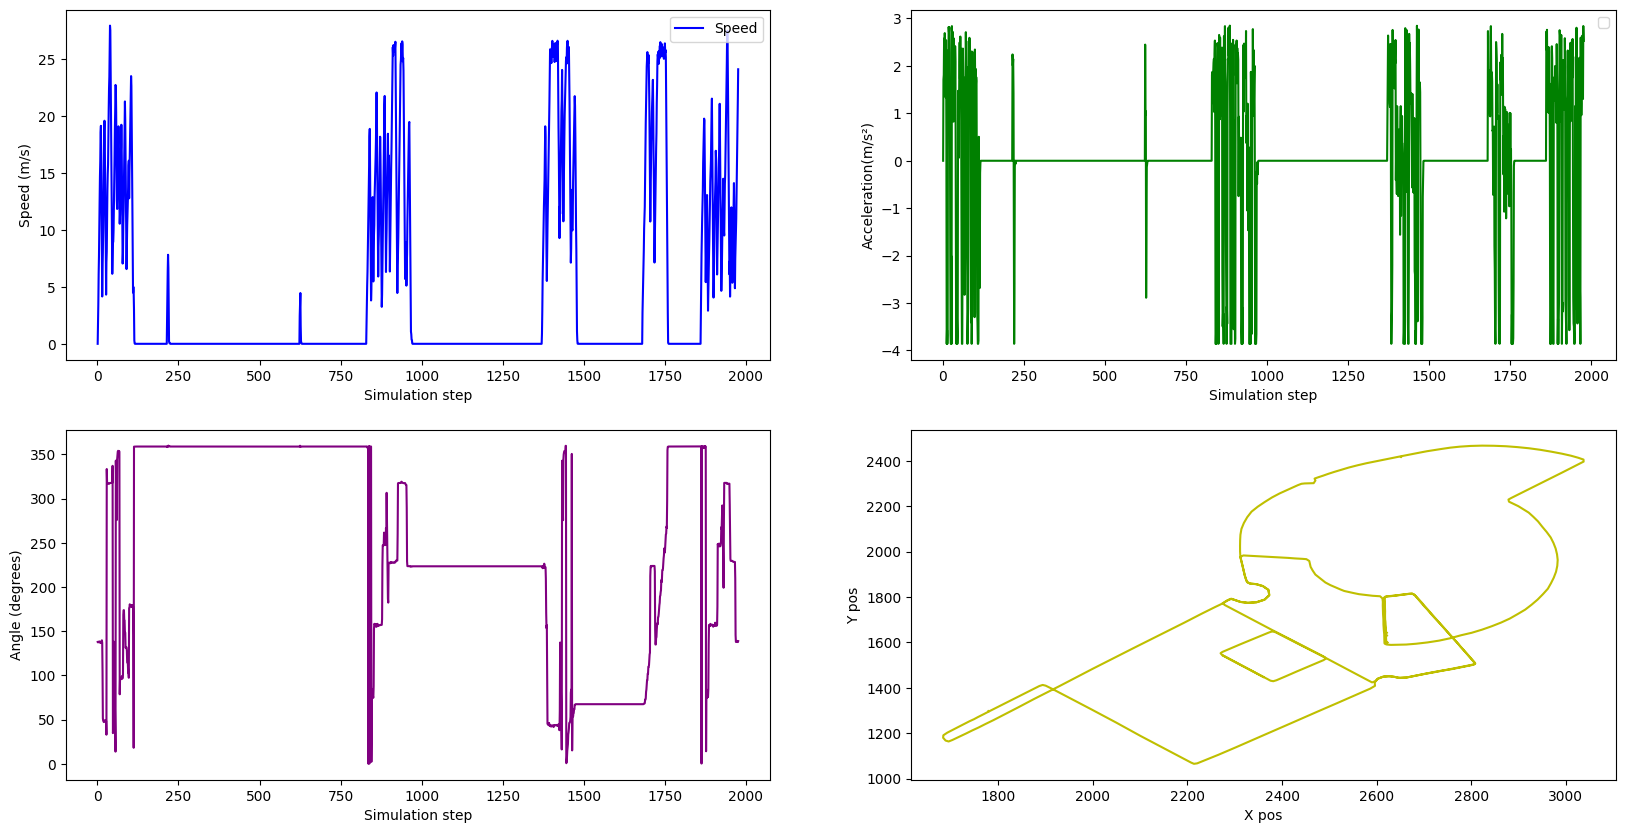

In [55]:
# Plot para o veículo 1 (aggressive)
static_plots(veh_variables, "veh1", True)

Criando gráfico dinâmico que roda juntamente com a simulação: